# Instructions

# MetAltas analysis workflow

1. Run through with your initial atlas
2. Use the RT adjuster to mark the quality of the peaks and MSMS matches, and also adjust your RT bounds
3. Reload your atlas from the "get atlas" block
4. Export your atlas, filter out the compounds marked under id notes as remove.  Save and upload your new atlas
5. Repeat the analysis using your filtered atlas

# index
1. Import python packages
2. Create groups
3. Select groups
4. Create Atlases
5. Select Atlas
6. Annotate data
7. Correct RT bounds
8. Export results
9. Tools

In [2]:
# optional: run this block to adjust the width of the notebook.  Change the width percent.

from  IPython.core.display  import  display, HTML 
display(HTML("<style>.container { width:100% !important; }</style>"))


# 1. Import Python Packages
## Instructions: 

1. On the 3rd line of the block below, add your directory where your most recent metatlas code is stored (to the sys.path.insert line).
2. Only run this block once to load the metatlas python modules.  If the kernel dies, you will need to rerun this block.
3. Run the block with the "print fa.__file__" code line to double check that the printed output matches the directory in the sys.path.insert line of the prior block.
    If it does not match, then on the "kernel" dropdown, click restart and correct the path below before trying again.

In [1]:
%matplotlib notebook
import sys, os

# v edit this line
sys.path.insert(0,'/global/homes/FIRST-INITIAL-OF-USERNAME/USERNAME/REPOFOLDER/metatlas-master-20200416/metatlas-master/')
# ^ edit this line

from metatlas.helpers import fastanalysis as fa
from metatlas.helpers import dill2plots as dp
from metatlas.helpers import metatlas_get_data_helper_fun as ma_data
from metatlas.helpers import chromatograms_mp_plots as cp
from metatlas.helpers import chromplotplus as cpp
import metatlas.metatlas_objects as metob
from metatlas.helpers import mzmine_helpers as mzm
import qgrid
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display
import time
import dill
import numpy as np
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plot
import operator

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 100)

('NERSC=', True)


In [2]:
# check that first block registered metatlas directory correctly.  If it does not look the same, seek help!
print fa.__file__

/global/homes/s/smkosina/metatlas_repos/metatlas-master-20200416/metatlas-master/metatlas/helpers/fastanalysis.pyc


# Set project and output directories from your nersc home directory
1. Create a project folder name for this analysis.
2. Create a subdirectory name for the output, each run through you may want to create a new output folder.
3. When you run the block the folders will be created in your home directory.  If the directory already exists, the block will just set the path for use with future code blocks.

In [3]:
projectdirectory='/global/homes/FIRST-INITIAL-OF-USERNAME/USERNAME/PROJECTDIRECTORY/'  # <- edit this line
outputsubfolder='HILIC_POS_20190830/'  # <- edit this as 'chromatography_polarity_yyyymmdd/'

if not os.path.exists(projectdirectory):
    os.makedirs(projectdirectory)
output_dir = '%s%s' % (projectdirectory,outputsubfolder)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 2. Create Groups (named variables that hold your replicates of each sample)
1. On the first line of the block below, set the 'experiment' and 'name' variables to find your files.  
2. 'Experiment' is the folder name within global/project/projectdirs/metatlas/raw_data, that will be emailed to you when the files are uploaded to NERSC.  You can also look in the raw_data directory for the NERSC user who uploaded your files; your experiment folder should be in there.
3. 'name' is string that will match all of your files within that folder.  
4. % is a wildcard

In [8]:
files = dp.get_metatlas_files(experiment = '%ENTERSTRING%',name = '%ENTERSTRING%',most_recent = True)
# ^ edit the text string in experiment and name fields

df = metob.to_dataframe(files)
my_grid = qgrid.QGridWidget(df=df[['experiment','name','username','acquisition_time']])
my_grid.export()

In [6]:
len(files)

130

# Automated Group Maker

## 
1. Pick experiment folder (enter text search string in first block).  
2. Enter controlled vocabulary for control files to put select files into groups with COMMON HEADER and GROUP NAME (based on if vocab in filename, puts in one of these groups and vocab is the group name).
3. If your group name is not between _ 11 and 12 you can adjust those values in the split commands below

In [25]:
files = metob.retrieve('lcmsruns',experiment='%ENTERSTRING%',username='*')
for f in files:
    print(f.name)

In [26]:
controlled_vocab = ['QC','InjBl','ISTD'] #add _ to beginning. It will be stripped if at begining
version_identifier = 'g1'
file_dict = {}
groups_dict = {}
for f in files:
    k = f.name.split('.')[0]
    #     get index if any controlled vocab in filename
    indices = [i for i, s in enumerate(controlled_vocab) if s in k]
    if len(indices)>0:
        short_name = controlled_vocab[indices[0]].lstrip('_')
    else:
        short_name = k.split('_')[12]
    prefix = '_'.join(k.split('_')[:11])
    group_name = '%s_%s_%s'%(prefix,version_identifier,short_name)
    file_dict[k] = {'file':f,'group':group_name,'short_name':short_name}
    groups_dict[group_name] = {'items':[],'name':group_name,'short_name':short_name}

df = pd.DataFrame(file_dict).T
df.index.name = 'filename'
df.reset_index(inplace=True)#['group'].unique()
df.drop(columns=['file'],inplace=True)

for ug in groups_dict.keys():
    for file_key,file_value in file_dict.items():
        if file_value['group'] == ug:
            groups_dict[ug]['items'].append(file_value['file'])

df.head(10)

,filename,group,short_name
0,20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_FPS_MS1_0_InjBl-MeOH_IR01...,20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_FPS_MS1_g1_InjBl-MeOH,InjBl-MeOH
1,20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_FPS_MS1_0_InjBl-MeOH_IR02...,20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_FPS_MS1_g1_InjBl-MeOH,InjBl-MeOH
2,20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_FPS_MS1_0_InjBl-MeOH_IR03...,20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_FPS_MS1_g1_InjBl-MeOH,InjBl-MeOH
3,20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_FPS_MS1_0_InjBl-MeOH_IR04...,20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_FPS_MS1_g1_InjBl-MeOH,InjBl-MeOH
4,20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_FPS_MS1_0_InjBl-MeOH_IR05...,20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_FPS_MS1_g1_InjBl-MeOH,InjBl-MeOH
5,20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_FPS_MS1_0_InjBl-MeOH_IR06...,20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_FPS_MS1_g1_InjBl-MeOH,InjBl-MeOH
6,20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_FPS_MS1_0_InjBl-MeOH_IR07...,20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_FPS_MS1_g1_InjBl-MeOH,InjBl-MeOH
7,20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_FPS_MS1_0_InjBl-MeOH_IR08...,20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_FPS_MS1_g1_InjBl-MeOH,InjBl-MeOH
8,20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_FPS_MS1_0_InjBl-MeOH_IR09...,20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_FPS_MS1_g1_InjBl-MeOH,InjBl-MeOH
9,20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_FPS_MS1_0_InjBl-MeOH_IR10...,20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_FPS_MS1_g1_InjBl-MeOH,InjBl-MeOH


## Puts remaining files into groups with COMMON HEADER and GROUP NAME (based on common position in filename).  Shows long group name for each file, and short name (that can be used for plots, spreadsheets, etc)

In [23]:
groups = []
for group_key,group_values in groups_dict.items():
    g = metob.Group(name=group_key,items=group_values['items'],short_name=group_values['short_name'])
    groups.append(g)        
    for item in g.items:
        print(g.name,g.short_name,item.name)
    print('')

(u'20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_NEG_MSMS-v2_v1_SC-highUV-DES', u'SC-highUV-DES', u'20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_NEG_MSMS-v2_61_SC-highUV-DES_2_095.mzML')
(u'20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_NEG_MSMS-v2_v1_SC-highUV-DES', u'SC-highUV-DES', u'20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_NEG_MSMS-v2_64_SC-highUV-DES_3_053.mzML')
(u'20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_NEG_MSMS-v2_v1_SC-highUV-DES', u'SC-highUV-DES', u'20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_NEG_MSMS-v2_102_SC-highUV-DES_1_062.mzML')
(u'20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_NEG_MSMS-v2_v1_SC-highUV-DES', u'SC-highUV-DES', u'20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_NEG_MSMS-v2_87_SC-highUV-DES_4_104.mzML')

(u'20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_Q

# Store groups once happy.  Only do this once you KNOW you have files in correct groups.

In [ ]:
metob.store(groups)

# Register LCMS Runs into categorical groups from a file.
### You must assign your raw files into experimental groups for analysis.  These are used for downstream statistics and for selection of specific groups for filtering to subsets of files for analysis (Ex. just pos or just neg).  Typically, you will make one fileinfo sheet with all of your files for this experiment.  At a minimum, group names MUST contain the first 11 underscore delimited fields (DATE_NORTHENLABINITIALS_COLLABINITIALS_PROJ_EXP_SAMPSET_SYSTEM_COLUMN-method_SERIAL_POL_ACQ) and the 'SAMPLEGROUP' field.

Files are named in this format: DATE_NORTHENLABINITIALS_COLLABINITIALS_PROJ_EXP_SAMPSET_SYSTEM_COLUM
N-method_SERIAL_POL_ACQ_SAMPLENUMBER_ SAMPLEGROUP_REP_OPTIONAL_SEQ

1. Find the .tab file in your project directory.
2. Open in excel or other spreadsheet editor.
3. Fill out the group names as per above.
4. Save the file as .txt
5. Run the make groups block using store=False
6. Run the next block 'metob.to_dataframe(g) and check that the information looks correct
7. If it is correct, rerun the make groups block, using store=True.  If not, fix your file in excel and redo steps 5-7.

In [9]:
dp.make_empty_fileinfo_sheet('%s%s' % (projectdirectory,'empty_fileinfo_proj_exp_yyyymmdd.tab'),files)

In [11]:
g = dp.make_groups_from_fileinfo_sheet('%s%s' % (projectdirectory,'filled_fileinfo_proj_exp_yyyymmdd.txt'),
                                       filetype='tab',
                                       store=True)

In [9]:
metob.to_dataframe(g)

,creation_time,description,items,last_modified,name,unique_id,username
0,2019-08-14 00:53:53,nan,[u'8f99b84603a843d78f5cea4635fbb403'],2019-08-14 00:53:53,20190403_JJ_JFB_RossSeaSed_IODP374_PolEx2019Feb_QE119_Ag68377-924_USHXG01162_POS_MSMS-v2_23B1H11...,9999c48048934ec08fd9e515aee3c353,smkosina
1,2019-08-14 00:53:54,nan,[u'84507610d142448389e7602adca22516'],2019-08-14 00:53:54,20190403_JJ_JFB_RossSeaSed_IODP374_PolEx2019Feb_QE119_Ag68377-924_USHXG01162_NEG_MSMS-v2_24B1H5015,8de8c06fdbf446bb9faa78c3076099e2,smkosina
2,2019-08-14 00:53:54,nan,[u'20e05602058249608e0743ca8fda7577'],2019-08-14 00:53:55,20190403_JJ_JFB_RossSeaSed_IODP374_PolEx2019Feb_QE119_Ag68377-924_USHXG01162_NEG_MSMS-v2_23B1H34050,328921c1d2704828acba88cf5c60b8c2,smkosina
3,2019-08-14 00:53:55,nan,[u'2c8ef2cb1a0042c09059c0e0fdbc0371'],2019-08-14 00:53:55,20190403_JJ_JFB_RossSeaSed_IODP374_PolEx2019Feb_QE119_Ag68377-924_USHXG01162_NEG_MSMS-v2_24B1H4015,bf8f9c1154af4eb7aa0ab386750a2549,smkosina
4,2019-08-14 00:53:55,nan,[u'79634f551c794463900d93c14a8cf987'],2019-08-14 00:53:56,20190403_JJ_JFB_RossSeaSed_IODP374_PolEx2019Feb_QE119_Ag68377-924_USHXG01162_POS_MSMS-v2_23B1H19...,818f807dc41a4e4388c000f9884edf2c,smkosina
5,2019-08-14 00:53:56,nan,[u'9ebf95b05af0464ca8d7638cd4351288'],2019-08-14 00:53:57,20190403_JJ_JFB_RossSeaSed_IODP374_PolEx2019Feb_QE119_Ag68377-924_USHXG01162_POS_MSMS-v2_23B1H39...,c6a8e66317854a0aa601d8f9721ee0ae,smkosina
6,2019-08-14 00:53:57,nan,[u'647ce07067ab416aa94bf5774149af63'],2019-08-14 00:53:57,20190403_JJ_JFB_RossSeaSed_IODP374_PolEx2019Feb_QE119_Ag68377-924_USHXG01162_NEG_MSMS-v2_24B1H34055,c3c3ee78d6ce42f4aab1e917b0db248b,smkosina
7,2019-08-14 00:53:57,nan,[u'4e4be01cc5ed4675bc128fa9fbb5ea5a'],2019-08-14 00:53:58,20190403_JJ_JFB_RossSeaSed_IODP374_PolEx2019Feb_QE119_Ag68377-924_USHXG01162_POS_MSMS-v2_23B1H63040,ffe2c03e5d7d44a89c33fac398032f4c,smkosina
8,2019-08-14 00:53:58,nan,[u'44e00d51ff754723bb38212fd23de5c4'],2019-08-14 00:53:58,20190403_JJ_JFB_RossSeaSed_IODP374_PolEx2019Feb_QE119_Ag68377-924_USHXG01162_POS_MSMS-v2_23B1H34050,591304293ac94c6fa4c478b69ef05749,smkosina
9,2019-08-14 00:53:58,nan,[u'435655d9f17d4433a7e843696727bf8e'],2019-08-14 00:53:59,20190403_JJ_JFB_RossSeaSed_IODP374_PolEx2019Feb_QE119_Ag68377-924_USHXG01162_POS_MSMS-v2_24B1H44055,a26adfe1dbec490cb8039cdc5c18514b,smkosina


# 3. Select groups of files to operate on
### fill out the fields for name, include_list and exclude_list using text strings from the group names you created in the previous step.
### Typically, you will run one polarity at a time.

In [4]:
dp = reload(dp)
groups = dp.select_groups_for_analysis(name = '%ENTERSEARCHSTRING%',    # <- edit text search string here
                                       most_recent = True,
                                       remove_empty = True,
                                       include_list = [], exclude_list = ['NEG','QC','InjBl'])# ex. ['QC','Blank'])
print("sorted groups")
groups = sorted(groups, key=operator.attrgetter('name'))
for i,a in enumerate(groups):
    print(i, a.name)

/global/common/software/m2650/python-cori/lib/python2.7/site-packages/pymysql/cursors.py:166: Warning: (1287, "'@@tx_isolation' is deprecated and will be removed in a future release. Please use '@@transaction_isolation' instead")
  result = self._query(query)


10
(0, u'20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_POS_MSMS-v2_SC-lowUV-DES', datetime.datetime(2019, 8, 30, 17, 56, 9))
(1, u'20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_POS_MSMS-v2_SC-lowUV-HYD', datetime.datetime(2019, 8, 30, 17, 56, 14))
(2, u'20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_POS_MSMS-v2_BR-highUV-HYD', datetime.datetime(2019, 8, 30, 17, 56, 17))
(3, u'20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_POS_MSMS-v2_SC-highUV-DES', datetime.datetime(2019, 8, 30, 17, 56, 19))
(4, u'20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_POS_MSMS-v2_SC-highUV-HYD', datetime.datetime(2019, 8, 30, 17, 56, 22))
(5, u'20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_POS_MSMS-v2_ExCtrl-NA-NA', datetime.datetime(2019, 8, 30, 17, 56, 58))
(6, u'20190703_JJ_JE_UVMoss_Chamber0206_SolUVAC_QE119_Ag68377-924_USHXG01162_POS_MSMS-v2_TxCtlr-NA-water', 

# 4. Create new Atlas entries in the Metatlas database from a csv file

## add links to QC, IS, and EMA atlases on google drive (check file permissions, make sure just for northenlab group)

1. Create your atlas as a csv file
2. Save it with the type of atlas (EMA, QC or IS), your initials, the experiment name, the polarity, and the version or timestamp
3. Upload it to your nersc project directory (the one you named above).  (If it doesn't work, double check your file permissions are set to at least rw-rw----).
4. Run blocks below to create the DB entries for negative and positive mode atlases
5. WARNING: Don't run this block over and over again - it will create multiple new DB entries with the same atlas name

# NEGATIVE MODE ATLAS UPLOAD

In [6]:
dp = reload(dp)
atlasfilename='EMA_SK_20190703_UVMoss_Chamber0206_SolUVAC_QE119_HIL_NEG_20190829_1735'
names = dp.make_atlas_from_spreadsheet('%s%s%s' % (projectdirectory,atlasfilename,'.csv'),
                                       atlasfilename,
                                       filetype='csv',
                                       sheetname='',
                                       polarity = 'negative',
                                       store=True,
                                       mz_tolerance = 20)
myAtlas = names    

# POSITIVE MODE ATLAS UPLOAD

In [7]:
dp = reload(dp)
atlasfilename='EMA_SK_20190703_UVMoss_Chamber0206_SolUVAC_QE119_HIL_POS_20190829_1735'
names = dp.make_atlas_from_spreadsheet('%s%s%s' % (projectdirectory,atlasfilename,'.csv'),
                                       atlasfilename,
                                       filetype='csv',
                                       sheetname='',
                                       polarity = 'positive',
                                       store=True,
                                       mz_tolerance = 10)
myAtlas = names       

# 5. Select Atlas to use

1. The first block will retrieve a list of atlases matching the 'name' string that you enter.  
2. The next block will select one from the list, using the index number.  Make sure to enter the index number for the atlas you want to use for your analysis by setting in this line: myAtlas = atlases[0]

In [4]:
atlases = metob.retrieve('Atlas',name='%UVMoss_Chamber0206_SolUVAC%POS%',username='YOUR-NERSC-USERNAME')
names = []
for i,a in enumerate(atlases):
    print(i,a.name,pd.to_datetime(a.last_modified,unit='s'))#len(a.compound_identifications)

(0, u'EMA_SK_20190703_UVMoss_Chamber0206_SolUVAC_QE119_HIL_POS_20190829_1735', Timestamp('2019-08-30 01:28:43'))


In [5]:
myAtlas = atlases[0]
atlas_df = ma_data.make_atlas_df(myAtlas)
atlas_df['label'] = [cid.name for cid in myAtlas.compound_identifications]
print myAtlas.name
# the first line of the output will show the dimensions of the atlas dataframe

((350, 15), 350)
EMA_SK_20190703_UVMoss_Chamber0206_SolUVAC_QE119_HIL_POS_20190829_1735
smkosina


In [39]:
# OPTIONAL: to view your atlas, run this block
print myAtlas.name
atlas_df

EMA_SK_20190222_Wildermuth_PMacbp4mut_Nov2018_QE144_HIL_POS_v20190612_2315


,inchi_key,compound_name,rt_max,rt_min,rt_peak,rt_units,detected_polarity,mz,mz_tolerance,mz_tolerance_units,mono_isotopic_molecular_weight,pubchem_compound_id,synonyms,inchi,label
0,LJUQGASMPRMWIW-UHFFFAOYSA-N,"5,6-Dimethylbenzimidazole",1.515590,0.015590,0.765590,min,positive,147.091698,20.0,ppm,146.084398,675,"5,6-Dimethylbenzimidazole///582-60-5///Dimedazol///Dimedazole///Dimesol///Dimezol///5,6-Dimethyl...","InChI=1S/C9H10N2/c1-6-3-8-9(4-7(6)2)11-5-10-8/h3-5H,1-2H3,(H,10,11)",dimethylbenzimidazole
1,NRPFNQUDKRYCNX-UHFFFAOYSA-N,4-Methoxyphenylacetic acid,1.544039,0.044039,0.794039,min,positive,184.096794,20.0,ppm,166.062994,7690,4-Methoxyphenylacetic acid///104-01-8///Homoanisic acid///2-(4-methoxyphenyl)acetic acid///4-Met...,"InChI=1S/C9H10O3/c1-12-8-4-2-7(3-5-8)6-9(10)11/h2-5H,6H2,1H3,(H,10,11)",4-methoxyphenylacetic acid
2,WHOOUMGHGSPMGR-UHFFFAOYSA-N,indole-3-acetaldehyde,1.597084,0.097084,0.847084,min,positive,160.075714,20.0,ppm,159.068414,800,indole-3-acetaldehyde///2-(1H-indol-3-yl)acetaldehyde///1H-indole-3-acetaldehyde///Indoleacetald...,"InChI=1S/C10H9NO/c12-6-5-8-7-11-10-4-2-1-3-9(8)10/h1-4,6-7,11H,5H2",indole-3-acetaldehyde
3,OZJPLYNZGCXSJM-UHFFFAOYSA-N,delta-Valerolactone,1.601539,0.101539,0.851539,min,positive,101.059730,20.0,ppm,100.052429,10953,delta-Valerolactone///542-28-9///5-Valerolactone///TETRAHYDRO-2H-PYRAN-2-ONE///oxan-2-one///2H-P...,InChI=1S/C5H8O2/c6-5-3-1-2-4-7-5/h1-4H2,5-valerolactone
4,JLIDBLDQVAYHNE-YKALOCIXSA-N,ABSCISIC ACID,1.633718,0.133718,0.883718,min,positive,265.143459,20.0,ppm,264.136159,5280896,"ABSCISIC ACID///21293-29-8///Abscisin II///(S)-(+)-Abscisic acid///(+)-Abscisic acid///(2Z,4E)-5...","InChI=1S/C15H20O4/c1-10(7-13(17)18)5-6-15(19)11(2)8-12(16)9-14(15,3)4/h5-8,19H,9H2,1-4H3,(H,17,1...",abscisic acid
5,KTHADMDGDNYQRX-UHFFFAOYSA-N,methyl 2-(1H-indol-3-yl)acetate,1.658208,0.158208,0.908208,min,positive,190.086279,20.0,ppm,189.078979,74706,methyl 2-(1H-indol-3-yl)acetate///1912-33-0///Methyl indole-3-acetate///Methyl 3-indolylacetate/...,"InChI=1S/C11H11NO2/c1-14-11(13)6-8-7-12-10-5-3-2-4-9(8)10/h2-5,7,12H,6H2,1H3",methyl indole-3-acetic acid
6,DRLFMBDRBRZALE-UHFFFAOYSA-N,Melatonin,1.658332,0.158332,0.908332,min,positive,233.128478,20.0,ppm,232.121178,896,Melatonin///Melatonine///73-31-4///N-Acetyl-5-methoxytryptamine///Circadin///5-Methoxy-N-acetylt...,"InChI=1S/C13H16N2O2/c1-9(16)14-6-5-10-8-15-13-4-3-11(17-2)7-12(10)13/h3-4,7-8,15H,5-6H2,1-2H3,(H...",melatonin
7,RSTKLPZEZYGQPY-UHFFFAOYSA-N,Indole-3-pyruvic acid,1.674867,0.174867,0.924867,min,positive,204.065543,20.0,ppm,203.058243,803,Indole-3-pyruvic acid///392-12-1///3-(1H-Indol-3-yl)-2-oxopropanoic acid///Indole-3-pyruvate///3...,"InChI=1S/C11H9NO3/c13-10(11(14)15)5-7-6-12-9-4-2-1-3-8(7)9/h1-4,6,12H,5H2,(H,14,15)",indole-3-pyruvic acid
8,HYVABZIGRDEKCD-UHFFFAOYSA-N,Isopentenyladenine,1.686586,0.186586,0.936586,min,positive,204.124395,20.0,ppm,203.117095,92180,Isopentenyladenine///2365-40-4///N-(3-METHYLBUT-2-EN-1-YL)-9H-PURIN-6-AMINE///IPADE///N6-Isopent...,"InChI=1S/C10H13N5/c1-7(2)3-4-11-9-8-10(13-5-12-8)15-6-14-9/h3,5-6H,4H2,1-2H3,(H2,11,12,13,14,15)",N6-(delta2-isopentenyl)-adenine
9,ZOAMBXDOGPRZLP-UHFFFAOYSA-N,indole-3-acetamide,1.690658,0.190658,0.940658,min,positive,175.086613,20.0,ppm,174.079313,397,indole-3-acetamide///879-37-8///3-Indoleacetamide///1H-Indole-3-acetamide///2-(1H-Indol-3-yl)ace...,"InChI=1S/C10H10N2O/c11-10(13)5-7-6-12-9-4-2-1-3-8(7)9/h1-4,6,12H,5H2,(H2,11,13)",indole-3-acetamide


# 6. Get EICs and MSMS for all files in your groups, using all compounds in your atlas.

### This block builds the metatlas_dataset variable.  This holds your EIC data (mz, rt, intensity values within your mz and rt ranges).

1. Change the value in "extra_time = 0.0" to something like 0.5 to 1.0 for the first EMA runthrough on your files.  This will take longer but collect msms outside your retention windows which allows you to check the msms of nearby peaks before adjusting your rt bounds around the correct peak.
2. extra_mz should almost always be set to 0.0   If you need to troubleshoot a low mz compound you could potentially use this value to run it back through with a larger mz error window than what was specified in your atlas (ppm tolerance).

In [23]:
all_files = []
for my_group in groups:
    for my_file in my_group.items:
        extra_time=0.1  
        extra_mz=0.00
        all_files.append((my_file,my_group,atlas_df,myAtlas,extra_time,extra_mz))
pool = mp.Pool(processes=min(4, len(all_files)))
t0 = time.time()
metatlas_dataset = pool.map(ma_data.get_data_for_atlas_df_and_file, all_files)
pool.close()
pool.terminate()
print time.time() - t0

82.7787179947


### One of the two blocks below builds the hits variable.  This holds your MSMS spectra (from within your mz, and rt ranges, and within the extra time indicated above).

There are two options for generating the hits variable:
1. block A: use when your files have msms
2. block B: only run if your files were collected in MS1 mode

In [ ]:
##BLOCK A

dp=reload(dp)
t0 = time.time()
print datetime.datetime.now()
hits=dp.get_msms_hits(metatlas_dataset,extra_time=True,keep_nonmatches=True)
print datetime.datetime.now()
print time.time() - t0

In [ ]:
## BLOCK B (uncomment lines below to run this.  Only use when all data files are MS1)

#hits=pd.DataFrame([], columns=['database','id','file_name','msms_scan', u'score', u'num_matches', u'msv_query_aligned', u'msv_ref_aligned', u'name', u'adduct', u'inchi_key', u'precursor_mz'])
#hits.set_index(['database','id','file_name','msms_scan'], inplace=True)

# 7. Adjust Retention Times. 

This block creates and interactive plot.  The top panel displays MSMS from within the two green RT bounds selected below (rt min and max).  When the database holds reference spectra, mirror plots are generated with the reference spectra inverted below the sample spectra.  The lower panel displays the EICs overlayed for all of the files in your selected groups.  You can highlight one group red.  It is recommended that you do this for your extraction blank (or if not available, use a solvent injection blank).  This plot also displays radio buttons that can be interactively selected and will be exported in your final identifications table and in your atlas export.  Use these to mark peak/MSMS quality.

How to use:
1. On line two below, fill out the peak flags (list of strings)
2. On line three below, change color_me_red='' to include a text string that will select just your blank injection files
3. Use the up/down buttons on your keyboard to cycle through MSMS spectra within the RT bounds of the lower plot.
4. Use the horizontal rt min and rt max bars below the plots to adjust the rt bounds around your peak.  If there are multiple peaks, select one at a time and then click up/down to update the msms available in that new RT range.  If necessary evaluate your data in an external program such as mzmine to make sure you are selecting the correct peak.

DO NOT change your RT theoretical peak (the purple line).  It is locked from editing (unless you change a hidden parameter).  The measure retention time of your peak will be calculated and exported in your output files.  These will be compared with the RT theoretical and used in your evidence of identification table.

<IPython.core.display.Javascript object>


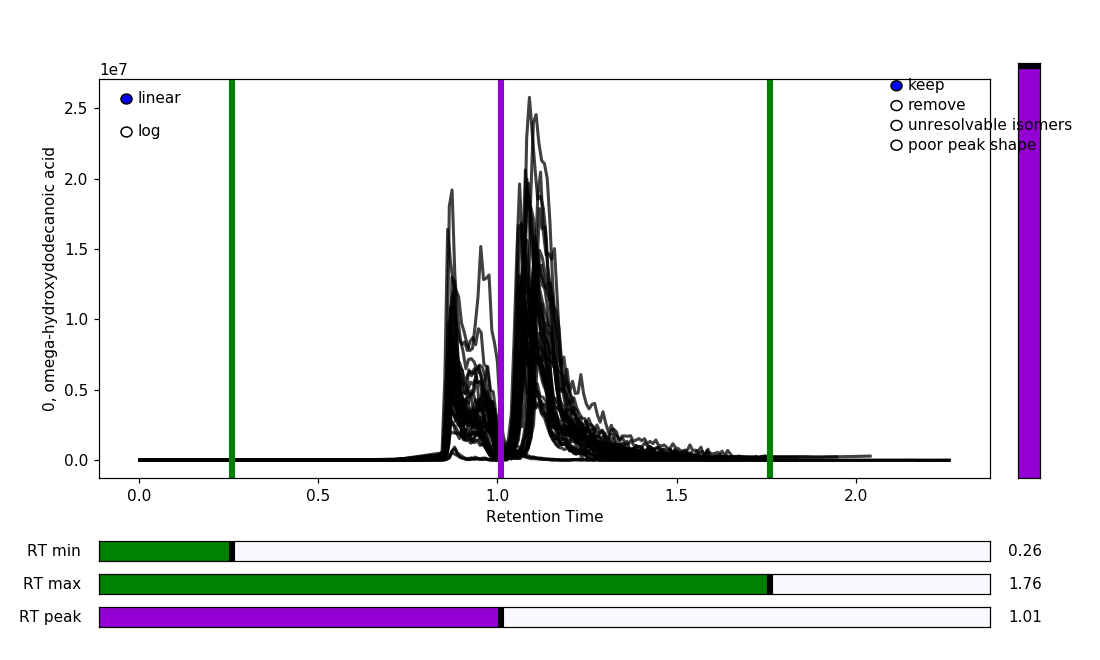

('loaded file for username = ', u'smkosina')


In [41]:
dp=reload(dp)
pkfl=('','L1+ - 1 pk, good RT&MSMS','L1+ - known isomer overlap','L1+ - 1 pk, good RT, MSMS ok (coisolated mz/partial match/low int)','L1+ - 1 pk, good RT&MSMS from external library','L1 - 1 pk, correct RT, no MSMS or int too low for matching','L1 - 1 pk, good RT, very low intensity/poor pk shape','L2 put comp','L3 putative class','Remove - background/noise','Remove - bad EMA MSMS','Remove - bad MSMS NIST/MONA/Metlin')
a = dp.adjust_rt_for_selected_compound(metatlas_dataset, msms_hits=hits,peak_flags=pkfl, color_me_red='ExCtrl', compound_idx=115,alpha=0.75,width=15,height=4.5)

# 8. Export results files

### Export Atlas to a Spreadsheet

In [25]:
atlas_identifications = dp.export_atlas_to_spreadsheet(myAtlas,os.path.join(output_dir,'%s%s.csv' % (myAtlas.name,"export")))
print myAtlas.name

### Export MSMS match scores, stats sheets, and final identification table

In [ ]:
fa=reload(fa)
kwargs = {'min_intensity': 1e4,   # strict = 1e5, loose = 1e3
          'rt_tolerance': .5,    #>= shift of median RT across all files for given compound to reference
          'mz_tolerance': 20,      # strict = 5, loose = 25; >= ppm of median mz across all files for given compound relative to reference
          'min_msms_score': .6, 'allow_no_msms': True,     # strict = 0.6, loose = 0.3 <= highest compound dot-product score across all files for given compound relative to reference
          'min_num_frag_matches': 1, 'min_relative_frag_intensity': .001}   # strict = 3 and 0.1, loose = 1, 0.01 number of matching mzs when calculating max_msms_score and ratio of second highest to first highest intensity of matching sample mzs
scores_df = fa.make_scores_df(metatlas_dataset,hits)
scores_df['passing'] = fa.test_scores_df(scores_df, **kwargs)

pass_atlas_df, fail_atlas_df, pass_dataset, fail_dataset = fa.filter_atlas_and_dataset(scores_df, atlas_df, metatlas_dataset,

scores_df.to_csv(os.path.join(output_dir, 'compound_scores.csv'))
fa = reload(fa)
fa.make_stats_table(input_dataset = metatlas_dataset, msms_hits = hits,output_loc = output_dir,min_peak_height=1e5,use_labels=True,min_msms_score=0.01,min_num_frag_matches=1,include_lcmsruns = [],exclude_lcmsruns = ['QC'])

### Faster Chromatogram plots (beta)

1.  There are three options for formatting your EIC output using the "group =" line below:
a. 'page' will print each sample group on a new page of a pdf file
b. 'index' will label each group with a letter
c. None will print all of the groups on one page with very small subplot labels
2. The Y axis scale can be shared across all files using share_y = True or set to the max within each file using share_y = False

In [26]:
## THINGS YOU MIGHT WANT TO CHANGE
group = 'index' # 'page' or 'index' or None
save = True
share_y = True
cpp=reload(cpp)
## THINGS YOU PROBABLY DON'T WANT TO CHANGE
file_names = ma_data.get_file_names(metatlas_dataset)
compound_names = ma_data.get_compound_names(metatlas_dataset,use_labels=True)[0]
args_list = []

chromatogram_str = 'compound_chromatograms2'

if not os.path.exists(os.path.join(output_dir,chromatogram_str)):
    os.makedirs(os.path.join(output_dir,chromatogram_str))

for compound_idx, my_compound in enumerate(compound_names):
    my_data = list()
    for file_idx, my_file in enumerate(file_names):
        my_data.append(metatlas_dataset[file_idx][compound_idx])
    kwargs = {'data': my_data,
             'file_name': os.path.join(output_dir, chromatogram_str, my_compound+'.pdf'),
             'group': group,
             'save': save,
             'share_y': share_y,
             'names': file_names,
             'shortname':dp.findcommonstart(file_names)}
    args_list.append(kwargs)
max_processes = 4
pool = mp.Pool(processes=min(max_processes, len(metatlas_dataset[0])))
pool.map(cpp.chromplotplus, args_list)
pool.close()
pool.terminate()

/global/common/software/m2650/python-cori/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/global/homes/s/smkosina/metatlas-master-20190617/metatlas-master/metatlas/helpers/chromplotplus.py:152: RuntimeWarning: invalid value encountered in less_equal
  for i,e in enumerate(eic_lines)]
/global/common/software/m2650/python-cori/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/global/homes/s/smkosina/metatlas-master-20190617/metatlas-master/metatlas/helpers/chromplotplus.py:152: RuntimeWarning: invalid value encountered in less_equal
  for i,e in enumerate(eic_

* ### Identification Figures

In [27]:
dp = reload(dp)
dp.make_identification_figure_v2(input_dataset = metatlas_dataset, use_labels=True,input_fname = my_file, include_lcmsruns = [],exclude_lcmsruns = ['InjBl','QC','Blank','blank'], output_loc=os.path.join(output_dir,'identification'))

RDKit ERROR: [11:16:50] ERROR: Sanitization error: Explicit valence for atom # 10 S, 8, is greater than permitted
RDKit ERROR: [11:51:34] Explicit valence for atom # 10 S, 8, is greater than permitted


### OPTIONAL WAY OF FILTERING ATLAS:  after exporting EIC/MSMS plots, move them into named folders (L1 plus, L1, remove, etc.), then copy the foldres back to nersc and run the blocks below to export a list of compound files in named folders.  Use that spreadsheet to filter your atlas.

In [ ]:
import glob
#dir_of_folders="C:/Users/Suzie/Desktop/P - Wildermuth/HILIC/HILIC_NEG_20190612_01/compound_chromatograms2/"
dir_of_folders="/global/u2/s/smkosina/2019 UV Moss/HILIC/HILIC_POS_20190830/chromatograms_sorted/"

subdir="*"
globdir="%s%s" % (dir_of_folders,subdir)
dir_fold_len=len(dir_of_folders)
dir_fold_len
globdir
#raw_list = glob.glob("Z:/Users/standards/20161209_SK_Standards_MSMLS_QE144_50447-638867/*.raw") #create list of files
folder_list = glob.glob(globdir)#create list of files
folder_list

In [ ]:
outfile="%s%s" % (dir_of_folders,"ListOfCompoundAnnotations.txt")

newfile=open(outfile,'wb')
for each in folder_list:
    label=each[dir_fold_len:]
    new_dir="%s%s%s" % (dir_of_folders,label,"/*")
    len_new_dir=len(new_dir)
    files_list=glob.glob(new_dir)
    for each2 in files_list:
        id_file=each2[len_new_dir-1:]
        print(id_file,label)
        newfile.write('%s\t%s\n' % (id_file,label))
newfile.close()